# Критерий Манна-Уитни добро или зло? 

*Преамбула:* 
Тест Манна-Уитни является одним из непараметрических тестов и не имеет жестких требований к распределению,  
игнорирует выборосы, не требует больших вычислетельных ресурсов и применять его можно даже к выборкам небольшого размера.  
Все это делает тест очень привлекательным для начинающего аналитика, однако среди более коллег существует мнение,  
что данный тест может давать странные результаты и в индустрии практически неприменим.  
Например, в [данной](https://habr.com/ru/companies/avito/articles/709596/) статье утверждается, что в Авито тест Манна-Уитни вообще не применяют,  
хотя раньше вроде как [применяли](https://habr.com/ru/companies/avito/articles/454164/).  
В данном ноутбуке я хочу не только рассмотреть случай, в котором U-тест работает некорректно, но и попытаться найти случаи, где он может в чем-то превосходить T-test.

In [2]:
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [56]:
import warnings
warnings.filterwarnings('ignore')

Как работает критерий Манна-Уитни я объяснять не буду, так как это легко гуглится.  
Замечу только то, что при подсчете статистики мы заменяем сами значения в выборках примерно на их номер в отсортированной выборке из элементов обеих выборок.  
Давайте попробует сыграть на этом и "сломать" тест.  

In [67]:
def gen_samples(sizes=[10 ** 4, 10 ** 3], means = [1, 10], draw_distr=True):
    assert len(sizes) == len(means), 'Массивы sizes и means должны быть одинаковой длины'

    X = []
    for size_, mean_ in zip(sizes, means):
        X.append(sps.expon.rvs(scale=mean_, size=size_))
    X_final = np.concatenate(X)

    if not draw_distr:
        return X_final
    
    with sns.axes_style('darkgrid'):
        plt.figure(figsize=(10, 6))
        x = np.linspace(0, max(means * 2), 500)
        for mean_ in means:
            plt.plot(x, sps.expon.pdf(x, scale=mean_), label=f'Exponential, mean={mean_}')

        sns.distplot(X_final, color='r', label='Распределение получившейся выборки', bins=100, hist_kws={'alpha': 0.3}, kde_kws={'label': 'kde получившейся выборки'})
        plt.axvline(x=X_final.mean(), linestyle='--', label='Среднее получившегося распределения', c='r')

        plt.xlim(0, 15)
        plt.ylabel('Probability Density')
        plt.legend()
        plt.show()
    return X_final
    

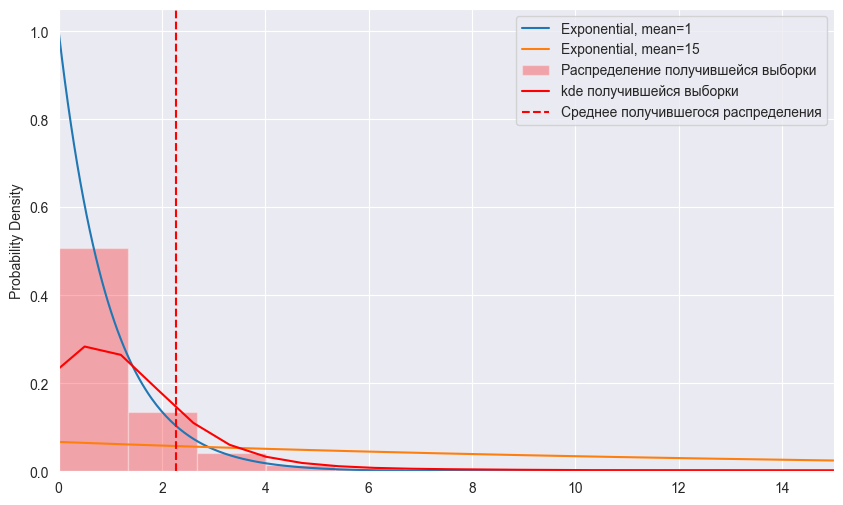

In [235]:
X1 = gen_samples(means = [1, 15])

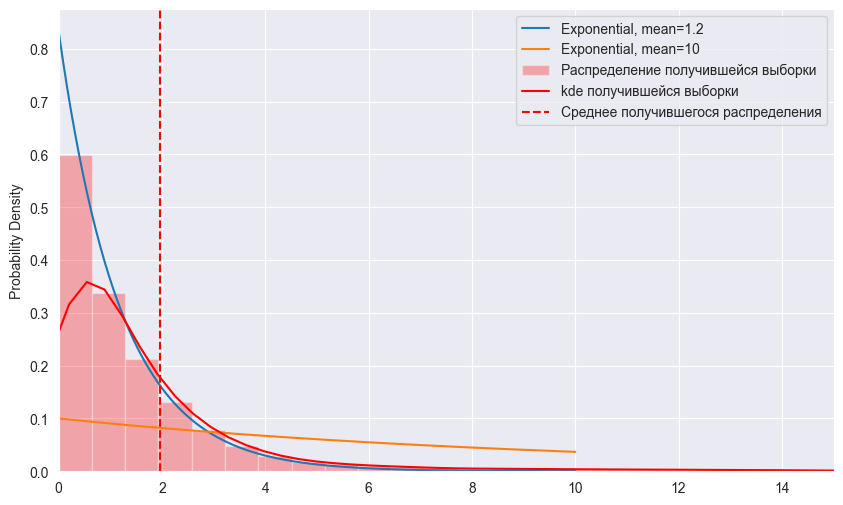

In [236]:
X2 = gen_samples(means = [1.2, 10])

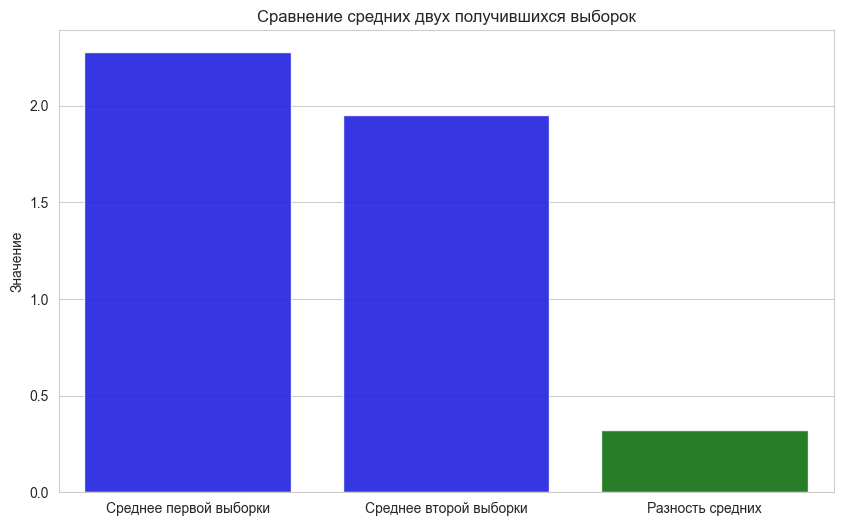

In [238]:
data = {'Column': ['Среднее первой выборки', 'Среднее второй выборки', 'Разность средних'],
        'Value': [X1.mean(), X2.mean(), X1.mean() - X2.mean()]}

with sns.axes_style('whitegrid'):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Column', y='Value', data=data, palette=['b', 'b', 'g'], alpha=0.9)
    plt.ylabel('Значение')
    plt.title('Сравнение средних двух получившихся выборок')
    plt.show()

Как можно видеть, среднее первой выборки больше, чем среднее во второй  
Проведем тесты Стьюдента и Манна-Уитни

In [81]:
_, pvalue = sps.ttest_ind(X1, X2, alternative='greater')
print('T-тест для альтернативы greater, p-value: {:.5f}'.format(pvalue))

T-тест для альтернативы greater, p-value: 0.00001


In [242]:
_, pvalue = sps.ttest_ind(X1, X2, alternative='greater')
print('T-тест для альтернативы greater, p-value: {:.5f}'.format(pvalue))

T-тест для альтернативы greater, p-value: 0.00000


In [241]:
_, pvalue = sps.mannwhitneyu(X1, X2, alternative='greater')
print('Тест Манна-Уитни для альтернативы greater, p-value: {:.5f}'.format(pvalue))

Тест Манна-Уитни для альтернативы greater, p-value: 1.00000


Мы получили диаметрально противоположные результаты тестов.  
В каком случае в индустрии мы могли получить подобные распределения? Давайте пофантазируем.  
Экспоненциальным распределением часто хорошо аппроксимируются траты пользователей.  
Пусть мы работаем в тинькофф путешествиях: у нас есть клиенты с премиумом - их мало и они много тратят на путешествия,  
обычных клиентов у нас много и на путешествия они тратят кратно меньше.  
Примерно так мы и генерировали данные - много точек из экспоненциального распределения с маленьким средним и мало точек из распределения с большим средним.  
Теперь пусть мы решили поменять текущую действующую акцию и провести тест.  
В контроле у нас акция кэшбек 10% за туры от 200к, а в тесте акция кэшбек 10% на туры от 20к до 50к.  
В таком случае в тесте уменьшатся траты на путешествия среди премиум клиентов, и увеличатся среди обычных и мы можем получить данные похожие на сгениророванные,  
посчитаем результаты U-тестом, увидим статзначимое улучшение, раскатим тест и уменьшим выручку (это все, если мы неграмотные аналитики).  
P. S. то что кэшбеком мы можем только обрушить финансовый результат мы не рассматриваем, пример игрушечный, отражает лишь общий смысл

Заметим, что тест Манна-Уитни обладает проблемами с интерпретируемостью, так как, например, финансовый результат отлично отражается средними тратами, а не рангами чиселок.

В чем проблема с U-тестом мы разобрались, теперь давайте попробуем разобраться когда он действительно может быть полезен (например когда мощность теста Манна-Уитни выше, чем у T-теста).

In [229]:
def compare_tests(distr, distr_label, shift, shift_label, N=1000, n_iter=1000, alt='two-sided', alpha1=0.05, aplha2=0.05, alpha=0.05):
    '''
        Функция принимает distr - функцию для генерации выборок
                          shift - значение, которое прибавляется ко второй выборке в тесте, может быть числом или np.array((n_iter, N))
                          N - размер выборок в каждом тесте
                          n_iter - количество итераций тестов
        Параметры aplha1, aplha2 нужны для того, чтобы в ручном режиме регулировать процент ошибок первого рода, если оно сильно отклоняется от целевого 0.05
        По полученным параметрам функция строит barplot, отражающий то, в каком проценте случаев мы отвергали/не отвергали 
                          нулевую гипотезу в тестах Стьюдента/Манна-Уитни
    '''

    X1 = distr.rvs(size=(n_iter, N))
    X2 = distr.rvs(size=(n_iter, N)) + shift
    t_reject, mw_reject = 0, 0
    for x, y in zip(X1, X2):
        t_reject += sps.ttest_ind(x, y, alternative=alt, equal_var=False)[1] < alpha1
        mw_reject += sps.mannwhitneyu(x, y, alternative=alt)[1] < aplha2
    
    data = {'Column': ['Отвергли T-test', 'Не отвергли T-test', 'Отвергли U-test', 'Не отвергли U-test'],
        'Value': [t_reject / n_iter, 1 - t_reject / n_iter, mw_reject / n_iter, 1 - mw_reject / n_iter]}

    with sns.axes_style('whitegrid'):
        plt.figure(figsize=(8, 8))
        sns.barplot(x='Column', y='Value', data=data, palette=['r', 'g', 'r', 'g'], alpha=0.9)
        plt.ylabel('%')
        plt.yticks(np.arange(0, 1.01, 0.05))
        plt.title(r'Сравнение тестов, выборки из {}, размер выборок: {}, количество итераций: {}, $\alpha = $ {}, shift = {}'.format(distr_label, N, n_iter, alpha, shift_label))
        plt.show()


Наиболее простой вариант добиться того, чтобы U-test работал лучше, чем t-test - сгенерить данные, на которых t-test работает не очень хорошо.  
Как мы знаем, часто для корректности работы теста Стьюдента необходимо, чтобы выборочные средние имели распределение похожее на нормальное,  
обычно даже для данных, имеющих распределение отличное от нормального это условие выполняется в силу ЦПТ, но для этого размер выборок должен быть достаточно большим.  
Попробуем на этом сыграть и провести тесты на выборках маленького размера.

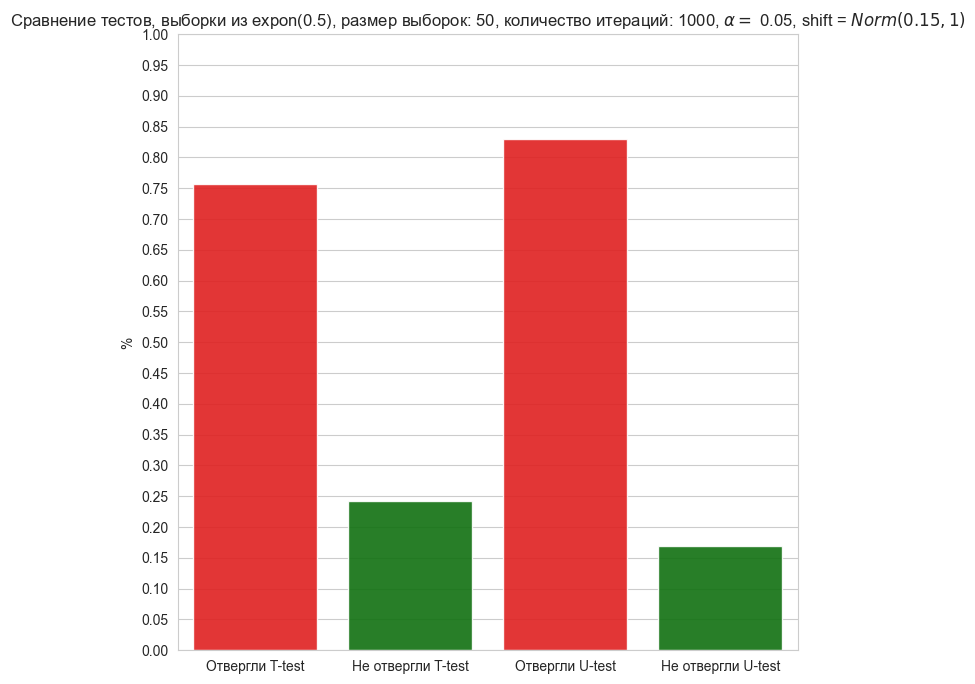

In [207]:
N=50
n_iter=2000
compare_tests(sps.expon(0.5), 'expon(0.5)', shift=sps.norm(0.65, 1).rvs(size=(n_iter, N)), shift_label=r'$Norm(0.15, 1)$', N=N, n_iter=n_iter)

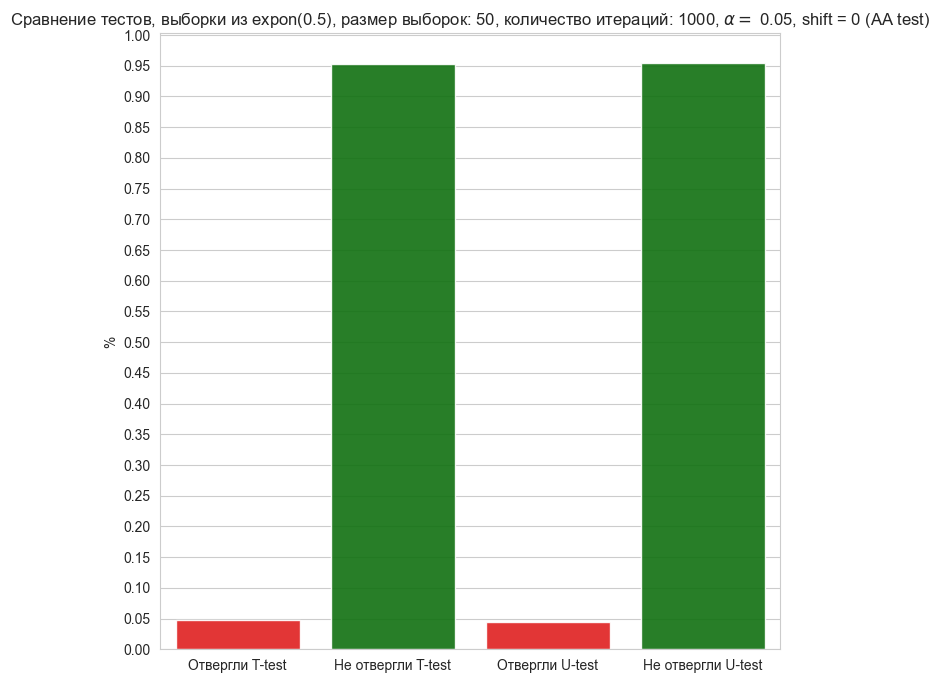

In [205]:
compare_tests(sps.expon(0.5), 'expon(0.5)', shift=0, shift_label=r'0 (AA test)', N=N, n_iter=n_iter)

Мощность U-теста получилась ~на 7% больше, что довольно существенно.  
При этом процент ложных прокрашиваний при АА тесте в обоих случаях примерно соответствует заданному.  
Давайте попробует увеличить размер выборок и посмотрим, как это повлияет на мощность тестов.

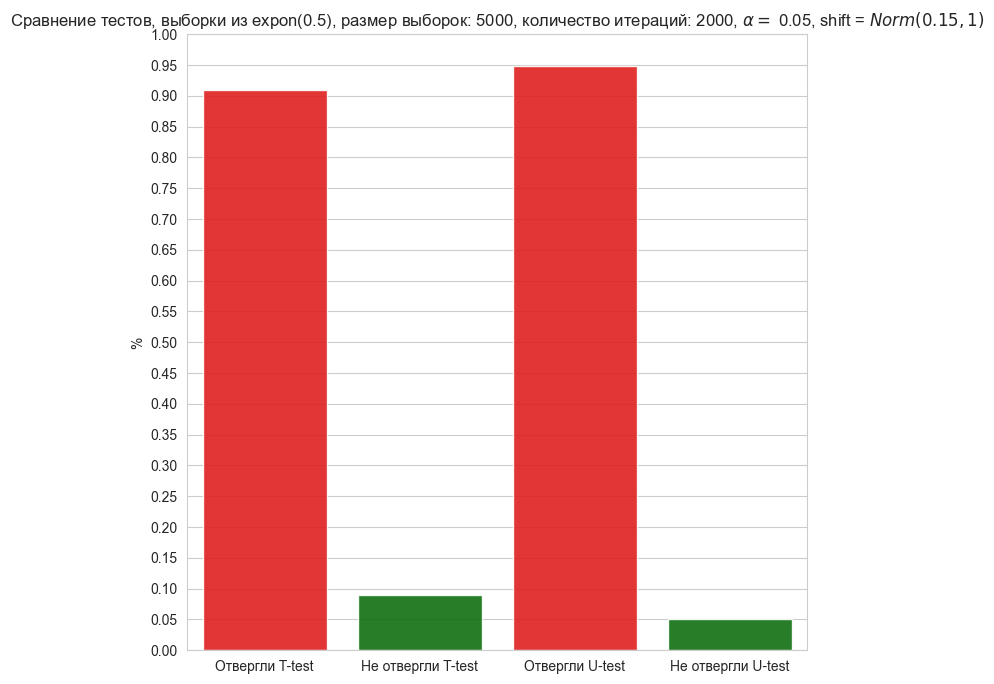

In [216]:
N=5000
n_iter=2000
compare_tests(sps.expon(0.5), 'expon(0.5)', shift=sps.norm(0.08, 1).rvs(size=(n_iter, N)), shift_label=r'$Norm(0.15, 1)$', N=N, n_iter=n_iter)

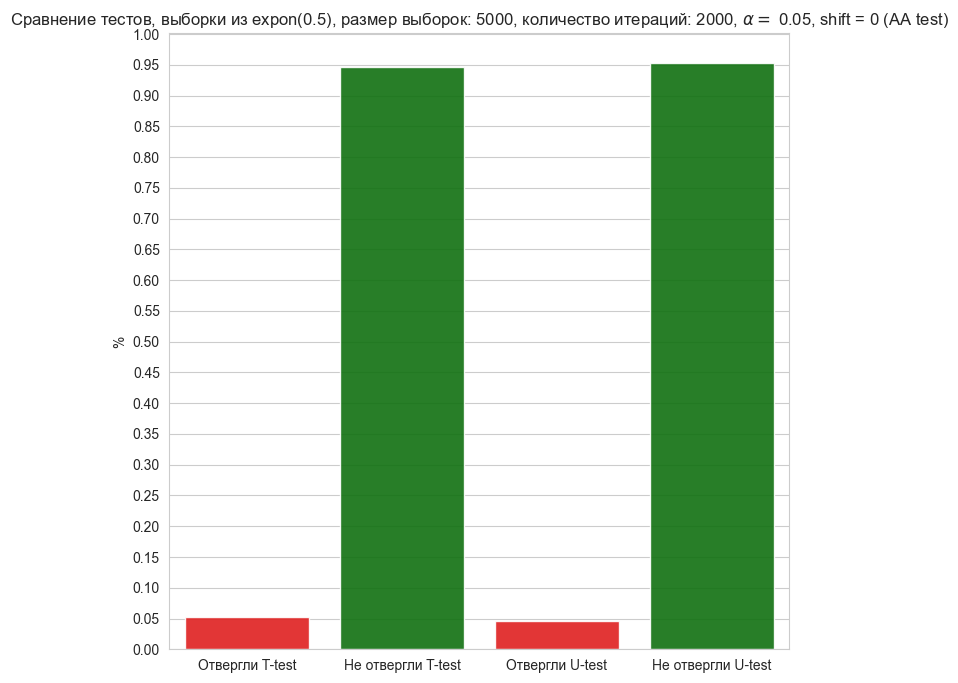

In [217]:
compare_tests(sps.expon(0.5), 'expon(0.5)', shift=0, shift_label=r'0 (AA test)', N=N, n_iter=n_iter)

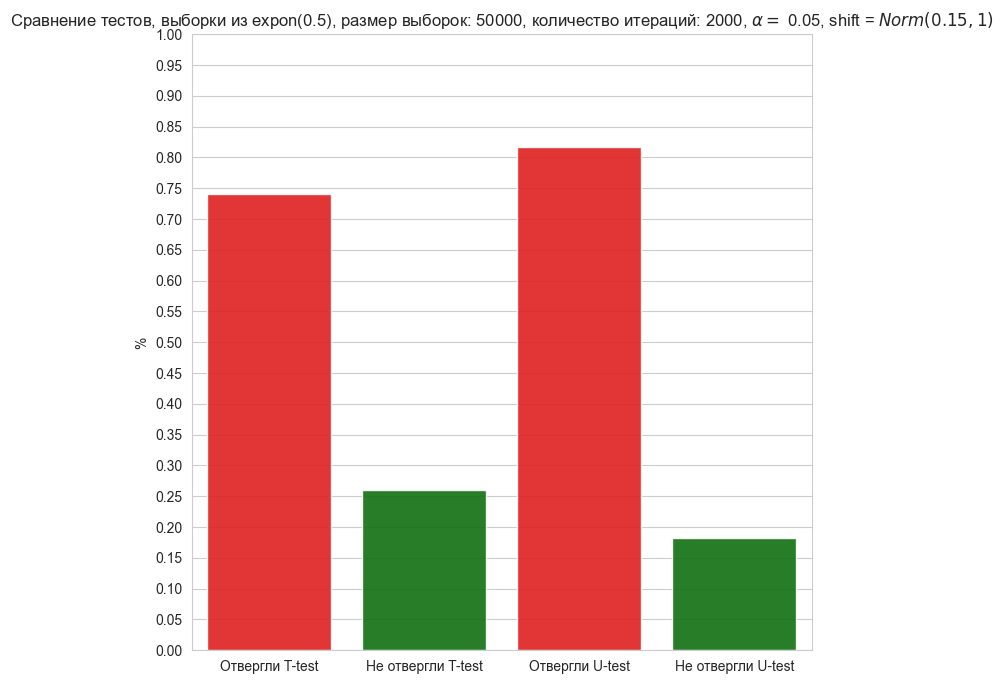

In [219]:
N=50000
n_iter=2000
compare_tests(sps.expon(0.5), 'expon(0.5)', shift=sps.norm(0.02, 1).rvs(size=(n_iter, N)), shift_label=r'$Norm(0.15, 1)$', N=N, n_iter=n_iter)

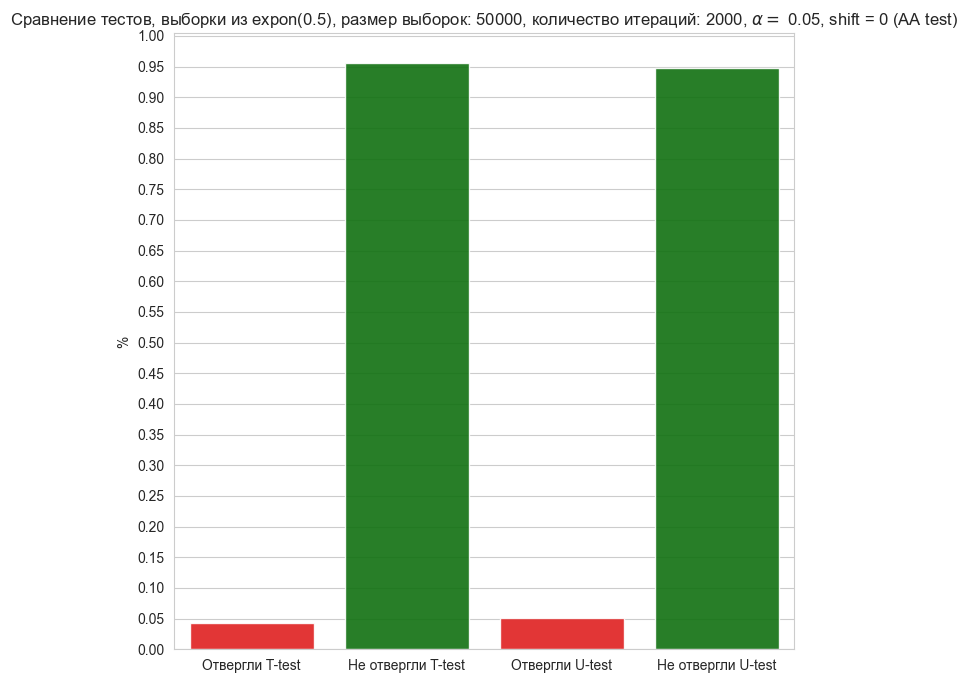

In [222]:
compare_tests(sps.expon(0.5), 'expon(0.5)', shift=0, shift_label=r'0 (AA test)', N=N, n_iter=n_iter)

Здесь картина аналогична, разница в мощностях статзначима, поверьте мне на слово).  
Предположение, которое можно сделать исходя из полученных данных - тест Манна-Уитни вполне может показывать мощность больше, чем у T-теста на выборках маленького и среднего размера

Давайте убедимся в том, что тест Стьюдента вообще может на обычных данных давать мощность больше, чем Манна-Уитни, как об этом принято писать в интернете.

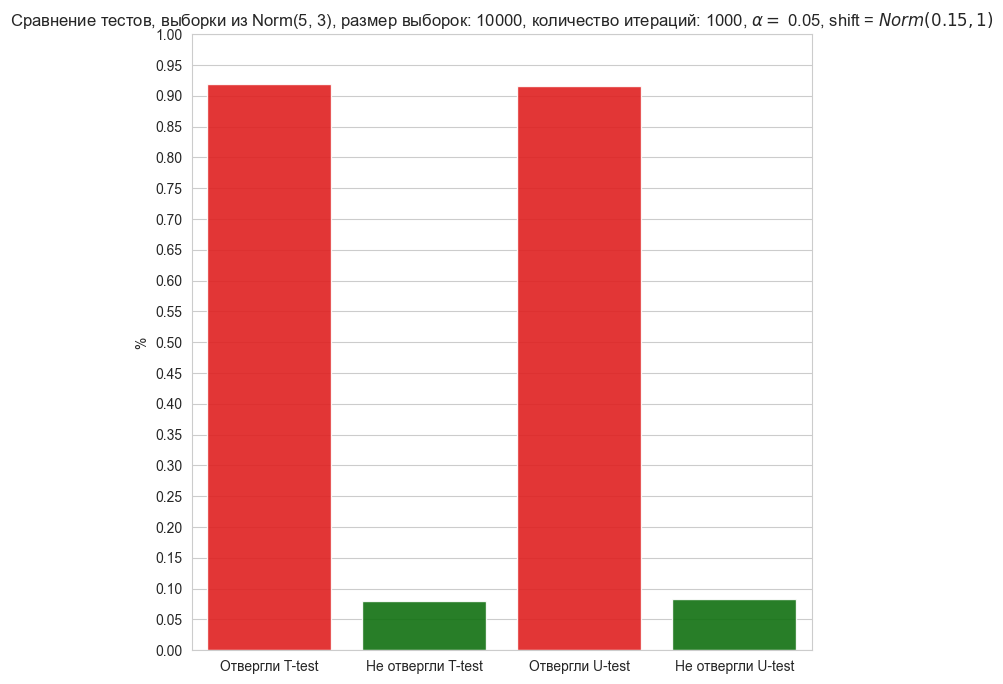

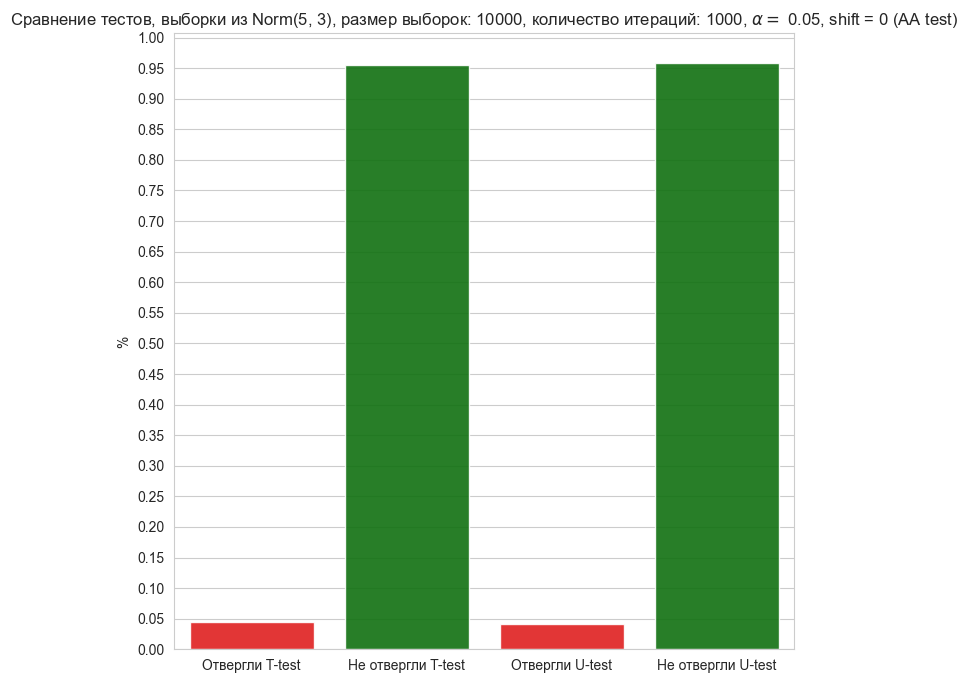

In [223]:
N=10000
n_iter=1000
compare_tests(sps.norm(5, 3), 'Norm(5, 3)', shift=sps.norm(0.15, 1).rvs(size=(n_iter, N)), shift_label=r'$Norm(0.15, 1)$', N=N, n_iter=n_iter)
compare_tests(sps.norm(5, 3), 'Norm(5, 3)', shift=0, shift_label=r'0 (AA test)', N=N, n_iter=n_iter)

Действительно может, хоть тут различия уже не так заметны, как в прошлом примере

Здесь было много ячеек с попытками получить для теста Манна-Уитни значительно большую мощность,  
чем у T-теста без добавления выборосов в данные. В итоге я их удалил, чтобы не забивать ноутбук одинаковыми графиками

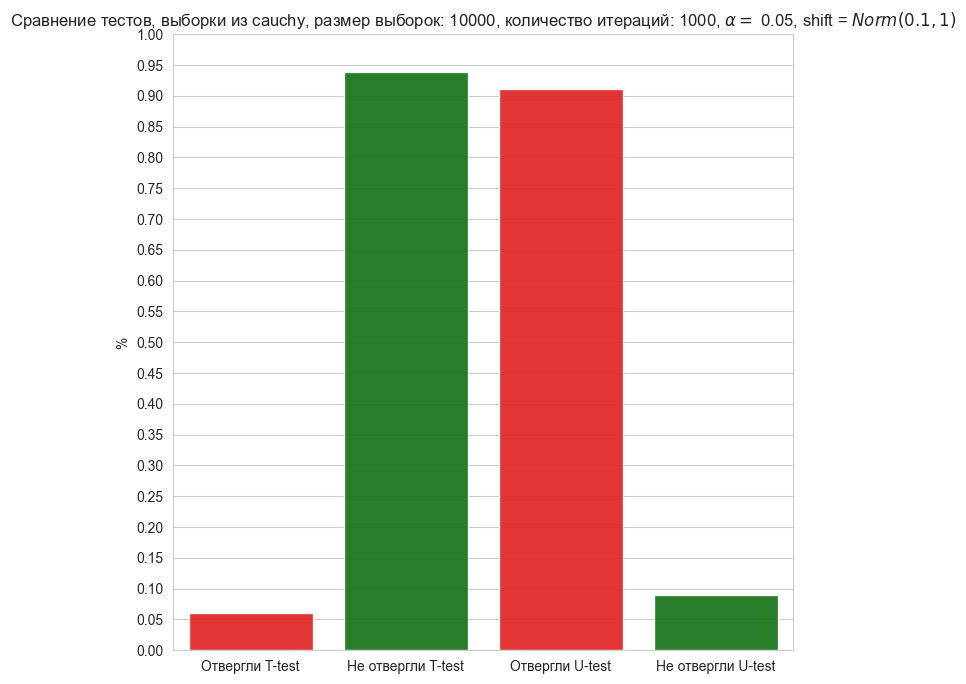

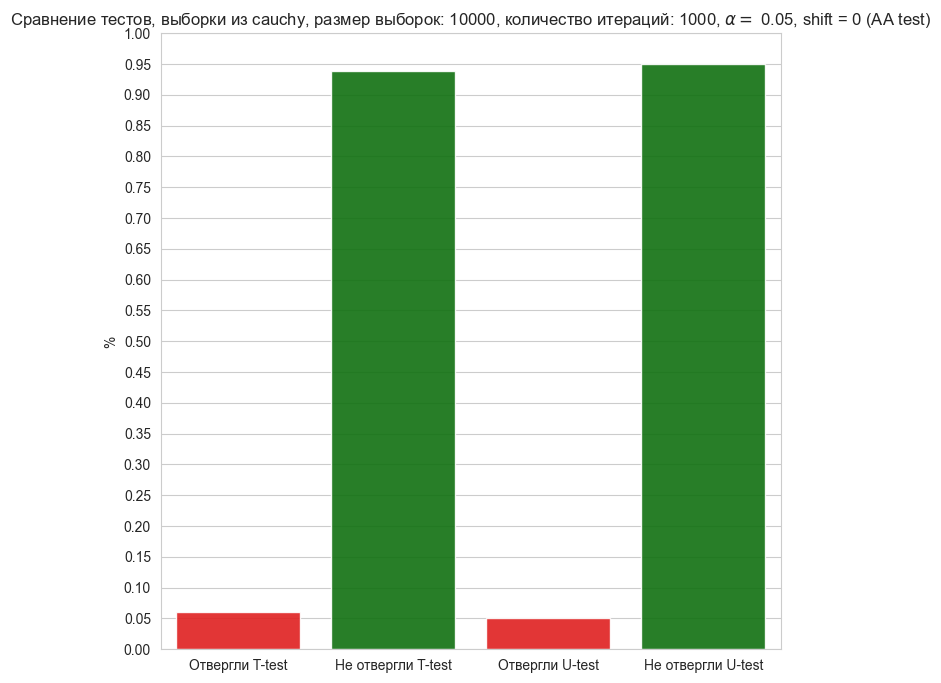

In [231]:
N=10000
n_iter=1000
compare_tests(sps.cauchy, 'cauchy', shift=sps.norm(0.1, 1).rvs(size=(n_iter, N)), shift_label=r'$Norm(0.1, 1)$', N=N, n_iter=n_iter, alpha1=0.10)
compare_tests(sps.cauchy, 'cauchy', shift=0, shift_label=r'0 (AA test)', N=N, n_iter=n_iter, alpha1=0.10)
# P.S понятно, что следует смотреть на доверительные интервалы на \alpha при АА тестах на этапе валидации, 
#   но суть ноутбука не в этом и в данном случае не совсем точное значение \alpha, импользуемое для T-теста глобально картину не изменит

     O_O
    (   )
     \_/

Что это такое? Тесты опять дают диаметрально противоположные результаты (причем корректно работает именно Манна-Уитни), хотя мы даже не пытались подстроиться на под один из них (или пытались?))

Давайте хоть посмотрим на наше распределение

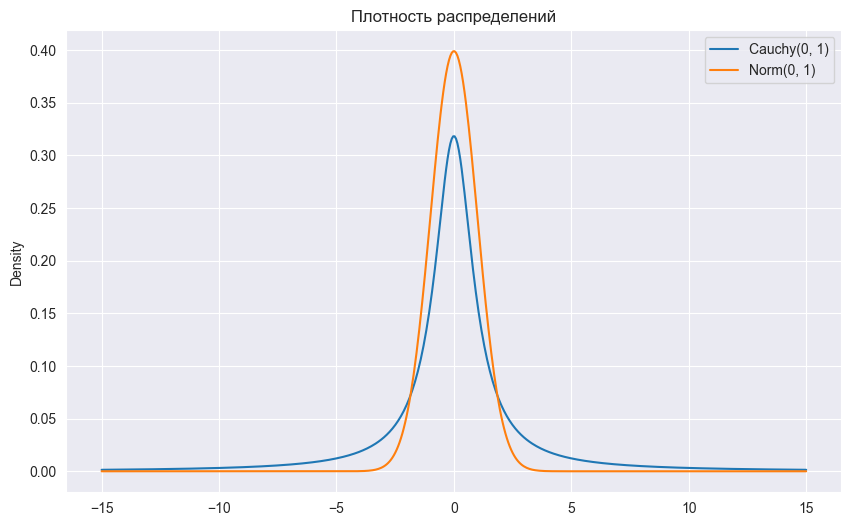

In [233]:
x = np.linspace(-15, 15, 500)

plt.figure(figsize=(10, 6))
plt.plot(x, sps.cauchy.pdf(x), label='Cauchy(0, 1)')
plt.plot(x, sps.norm.pdf(x), label='Norm(0, 1)')
plt.title('Плотность распределений')
plt.ylabel('Density')
plt.legend()
plt.show()

Видно, что распределение Коши имеет форму в целом схожую с нормальным, однако со значительно более тяжелыми "хвостами".  
Помимо этого открыв википедию, можно узнать, что данное распределение не имеет матожидания и дисперсии, что ломает ЦПТ.  
Так же распределение Коши устойчиво, из чего следует, что распределение выборочных средних из стандартного распределение Коши имеет стандартное распределение Коши, 
что тоже сигнализирует нам о том, что T-тест на нем не стоит применять.

При подсчете конверсий, средних чеков и других популярных метрик, которые считают в IT компаниях, вы вряд ли столкнетесь с этим распределением, однако
распределение не является исключительно теоретическим и встречается, например, в оптике, и при моделировании финансовых временных рядов. 

Следствием проведенных тестов и всего сказанного выше является то, что существуют данные, на которых тест Манна-Уитни работает корректно в отличии от теста Стьюдента, 
 причем с такими данными можно даже столкнуться в реальной жизни.

Изначально я хотел еще привести пример, когда U-test работает лучше теста Стьюдента за счет того, что является устойчивым к выбросам.  
Однако тема выборосов является спорной, поэтому я решил ограничиться текстовым описанием.  
Природу выборосов всегда следует исследовать: 
Если выбросы в данных связаны с единичными ошибками измерений или с техническими сбоями, то скорее всего стоит удалить их из данных (если ваше изменение не могло повлиять на ошибки измерений и технические сбои).  
В таком случае выбросы, которые изначально были в данных не окажут влияния на T-тест, который мы проводим на очищенных данных, и  
использование U-теста позволил бы нам просто не чистить данные от выбросов.  
Если же выбросы являются значимыми, например, есть очень маленькая группа людей, которая очень много донатит в сервис, то 
такие выборосы убирать нельзя и тест Манна-Уитни даст нам ложное представление о результате, так как значения выборосов игноририует.

*Заключение*  
Отвечая на вопрос, который ставился в начале ноутбука скажу, что тест Манна-Уитни - это однозначно добро, если пользоваться им с умом,  
так как существуют кейсы, в которых он работает лучше, чем, например, самый распространенный тест.  
Однако в случае бесконтрольного применения U-test легко превращается в зло, так как при его использовании  
очень легко неправильно интерпретировать результаты.  
Даже если вы не используете U-test для принятия решений, может быть полезно посмотреть на его результат и сравнить с полученным ранее.  
Большие различия могут быть хорошим стимулом задуматься о причине такого расхождения и перепроверить, что тест был проведен корректно.

# Бонус для дочитавших

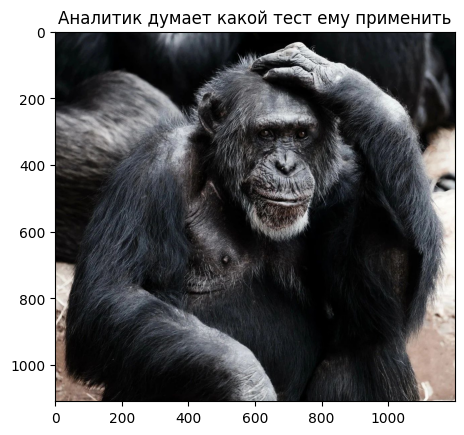

In [3]:
image = plt.imread('../monkeys/monkey3.jpg')
plt.title('Аналитик думает какой тест ему применить')
plt.imshow(image)
plt.show()